In [274]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from models.fair import BinaryFair
from models.flow import Flow
from models.classifier import BinaryClassifier
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.auto import trange
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_file = torch.load("data/Crime/data.pt")

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


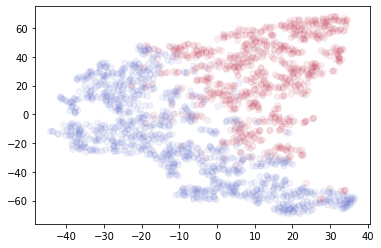

In [3]:
X_embedded = TSNE(n_components=2).fit_transform(data_file['data'])
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.07, cmap='coolwarm')

In [417]:
data = data_file['data']
context = data_file['context']
labels = data_file['labels']

In [418]:
data_train, data_test, context_train, context_test, labels_train, labels_test = train_test_split(data, context, labels, test_size=0.2)

In [422]:
context_train

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]])

In [425]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Split data by label
data_0 = data_train[context_train.flatten()==0]
labels_0 = labels_train[context_train.flatten()==0]
context_0 = context_train[context_train.flatten()==0]

data_1 = data_train[context_train.flatten()==1]
labels_1 = labels_train[context_train.flatten()==1]
context_1 = context_train[context_train.flatten()==1]

data_0_test = data_test[context_test.flatten()==0]
labels_0_test = labels_test[context_test.flatten()==0]
context_0_test = context_test[context_test.flatten()==0]

data_1_test = data_test[context_test.flatten()==1]
labels_1_test = labels_test[context_test.flatten()==1]
context_1_test = context_test[context_test.flatten()==1]

# data_0 = data_file['data'][data_file['context'].flatten() == 0]
# labels_0 = data_file['labels'][data_file['context'].flatten() == 0]
# context_0 = data_file['context'][data_file['context'].flatten() == 0]

# data_1 = data_file['data'][data_file['context'].flatten() == 1]
# labels_1 = data_file['labels'][data_file['context'].flatten() == 1]
# context_1 = data_file['context'][data_file['context'].flatten() == 1]

# Generators
label_0_set = TensorDataset(data_0, labels_0, context_0)
label_0_generator = torch.utils.data.DataLoader(label_0_set, **params)

label_1_set = TensorDataset(data_1, labels_1, context_1)
label_1_generator = torch.utils.data.DataLoader(label_1_set, **params)

label_0_set_test = TensorDataset(data_0_test, labels_0_test, context_0_test)
label_0_generator_test = torch.utils.data.DataLoader(label_0_set_test, **params)

label_1_set_test = TensorDataset(data_1_test, labels_1_test, context_1_test)
label_1_generator_test = torch.utils.data.DataLoader(label_1_set_test, **params)



In [160]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Generators
data_set = TensorDataset(data_file['data'], data_file['context'])
data_generator = torch.utils.data.DataLoader(data_set, **params)

In [426]:
probability_flow = Flow(data_dim=data_file['data'].shape[-1], 
                  context_dim=data_file['context'].shape[-1],
                  n_layers = 3,
                  transform_type = 'MaskedAffineAutoregressiveTransform', 
        )
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-3, weight_decay=1e-4)

In [427]:
n_steps = 2000
probability_loss = []
probability_flow.train()
for n_step in trange(n_steps):
    data, context = next(iter(data_generator))
    
    optimizer.zero_grad()

    loss = -probability_flow.log_prob(inputs=data, context=context).mean()
    probability_loss.append(loss.item())
    loss.backward()
    optimizer.step()
probability_flow.eval();

100%|██████████| 2000/2000 [00:14<00:00, 135.31it/s]


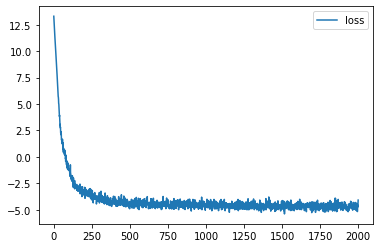

In [8]:
plt.plot(probability_loss, label="loss")
xlims = plt.xlim()
ylims = plt.ylim()
plt.legend()
plt.show()

In [9]:
probability_flow._log_prob(data_file['data'][0:1], None)

tensor([-7.6223], grad_fn=<AddBackward0>)

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


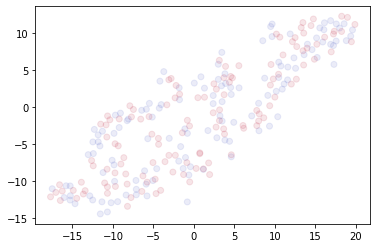

In [10]:
data, context = next(iter(data_generator))
data_embedded = TSNE(n_components=2).fit_transform(data)
samples = probability_flow._sample(num_samples=1, context=context)

catData = torch.cat((data, samples.squeeze(dim=1)))
catData_embedded = TSNE(n_components=2).fit_transform(catData.detach().numpy())
catLabel = torch.cat((torch.zeros(data.shape[0]), torch.ones(samples.shape[0])))

plt.scatter(*catData_embedded.T, c=catLabel, alpha=0.1, cmap='coolwarm')

In [243]:
gamma = 0.0
Fair = BinaryFair(data_dim=data_file['data'].shape[-1], 
                  context_dim=data_file['context'].shape[-1], 
                  flow_n_layers = 4,
                  flow_transform_type = 'MaskedAffineAutoregressiveTransform', 
                  classifier_hidden_dim = 32,
                  classifier_n_layers = 4,
                  classifier_activation = 'ReLU',
                  gamma=gamma
                 )
optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-3, weight_decay=1e-4)
total_losses = []
KL_losses = []
clf_losses = []

In [244]:
n_steps = 10
Fair.train()
for n_step in trange(n_steps):
    data_0, labels_0, context_0 = next(iter(label_0_generator))
    data_1, labels_1, context_1 = next(iter(label_1_generator))
    
    optimizer.zero_grad()

    L_KL, L_clf, loss = Fair.loss(data_0, data_1, labels_0=labels_0, labels_1=labels_1, context_0=context_0, context_1=context_1, return_all_losses=True, probability_flow=probability_flow)

    total_losses.append(loss.item())
    KL_losses.append(L_KL.item())
    clf_losses.append(L_clf.item())

    loss.backward()
    optimizer.step()
Fair.eval();

100%|██████████| 10/10 [00:00<00:00, 33.33it/s]


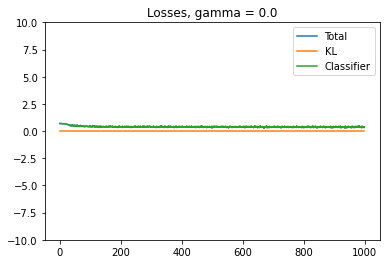

In [207]:
plt.plot(total_losses, label="Total")
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(KL_losses, label="KL")
plt.plot(clf_losses, label="Classifier")
plt.legend()
plt.xlim(*xlims)
plt.ylim(-10,10)
plt.title("Losses, gamma = " + str(gamma))
# plt.savefig("Figures/losses_gamma_" + str(gamma) + ".png")
plt.show()

In [14]:
#When gamma = 0, Fair.flow0._transform returns nans on the data
# Fair.flow0._transform(data_0, context=None)

Text(0.5, 1.0, 'Embedding, gamma = 0.0')

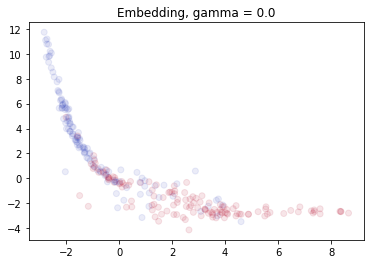

In [208]:
data_0, labels_0, _ = next(iter(label_0_generator))
data_1, labels_1, _ = next(iter(label_1_generator))

embedding_0, embedding_1 = Fair._embed(data_0, data_1, context_0=None, context_1=None)

plt.scatter(*embedding_0.T[0:2].detach(), alpha=0.1, c=labels_0, cmap='coolwarm')
plt.scatter(*embedding_1.T[0:2].detach(), alpha=0.1, c=labels_1, cmap='coolwarm')

plt.title("Embedding, gamma = " + str(gamma))
# plt.savefig("Figures/embedding_gamma_" + str(gamma) + ".png")

In [209]:
with torch.no_grad():
    cont_pred = Fair(data_file['data'], data_file['context'])
    bin_pred = (cont_pred > 0.5).int()
    acc = accuracy_score(bin_pred, data_file['labels'])
acc

0.8350050150451354

Accuracies:
    gamma = 0. : 0.84  # paper achieves 85.2 (not too far off)
    gamma = 1. : 0.5

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


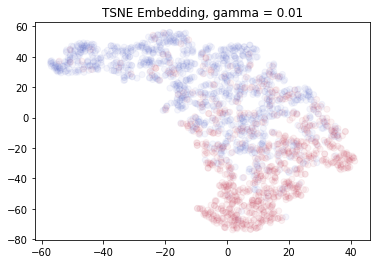

In [17]:
#Interpreting the representations
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    data_0 = data_file["data"][idx]
    data_1 = data_file["data"][~idx]

    # x0 = probability_flow.sample(num_samples=1, context=data_file["context"][idx]).squeeze()
    # x1 = probability_flow.sample(num_samples=1, context=data_file["context"][~idx]).squeeze()

    embedding_0, embedding_1 = Fair._fair_embed(
        x0=data_0, x1=data_1
    )
    embedding = torch.cat([data_0, embedding_0])
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
embed_labels = torch.cat([torch.zeros(data_0.shape[0]), torch.ones(embedding_0.shape[0])])
plt.scatter(*X_embedded.T, c=embed_labels, alpha=0.05, cmap="coolwarm")
plt.title("TSNE Embedding, gamma = " + str(gamma))
plt.savefig("Figures/tsne_clustering_gamma_" + str(gamma) + ".png")

For gamma = 1, these two should be on top of one another, but they're not!

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


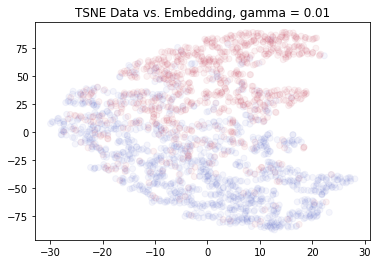

In [18]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx]
    )
    embedding = torch.cat([embedding_0, embedding_1])
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
    embed_labels = torch.cat([torch.zeros(embedding_0.shape[0]), torch.ones(embedding_1.shape[0])])
plt.scatter(*X_embedded.T, c=embed_labels, alpha=0.05, cmap="coolwarm")
plt.title("TSNE Data vs. Embedding, gamma = " + str(gamma))
plt.savefig("Figures/tsne_data_embedding_gamma_" + str(gamma) + ".png")


In [45]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx]
    )

EmpiricalStatisticalDistance(
    embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100
)


100%|██████████| 100/100 [00:08<00:00, 12.32it/s]

Training set accuracy: 0.586
Test set accuracy: 0.578


tensor(0.0085, grad_fn=<AbsBackward0>)

In [20]:
#Optimal Adversary
#TODO: need to add the context to the data
# idx = (data_file["context"] == 0).flatten()
# data_0 = data_file["data"][idx]
# data_1 = data_file["data"][~idx]
# context_0 = data_file["context"][idx]
# context_1 = data_file["context"][~idx]
data_0, labels_0, context_0 = next(iter(label_0_generator))
data_1, labels_1, context_1 = next(iter(label_1_generator))

mu_star_0_avg, mu_star_1_avg, stat_dist, logP_Z0_z0, logP_Z1_z1, logP_Z0_z1, logP_Z1_z0 = Fair.optimal_adversary(data_0, data_1, context_0=context_0, context_1=context_1, probability_flow=probability_flow)

In [21]:
print('gamma:', str(gamma), "mu_star_0_avg:", mu_star_0_avg, "mu_star_1_ave:", mu_star_1_avg, "stat_dist:", stat_dist)

gamma: 0.01 mu_star_0_avg: tensor(0.1875) mu_star_1_ave: tensor(0.8750) stat_dist: tensor(-0.6875)


gamma: 0.01 mu_star_0_avg: tensor(0.1875) mu_star_1_ave: tensor(0.8750) stat_dist: tensor(-0.6875)

gamma: 0.9 mu_star_0_avg: tensor(0.2812) mu_star_1_ave: tensor(0.5938) stat_dist: tensor(-0.3125)

(array([ 3.,  3., 17., 19., 23., 27., 12., 10.,  7.,  7.]),
 array([-6.4149027 , -5.5011477 , -4.5873923 , -3.6736374 , -2.7598822 ,
        -1.846127  , -0.9323719 , -0.01861677,  0.8951384 ,  1.8088934 ,
         2.7226486 ], dtype=float32),
 <BarContainer object of 10 artists>)

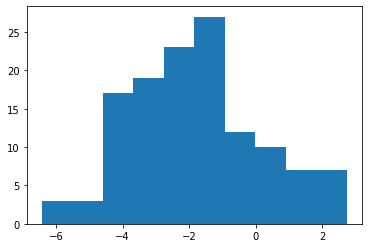

In [22]:
plt.hist((logP_Z1_z0-logP_Z0_z0).detach().numpy())

In [23]:
print(f'mu0 = {mu_star_0_avg}, mu1 = {mu_star_1_avg}, stat_dist = {stat_dist}')

mu0 = 0.1875, mu1 = 0.875, stat_dist = -0.6875


In [94]:
gammas = [0.001, 0.1, 0.2, 0.9]
Fairs = []

In [95]:
for gamma in gammas:
    Fair = BinaryFair(data_dim=data_file['data'].shape[-1], 
                    context_dim=data_file['context'].shape[-1], 
                    flow_n_layers = 4,
                    flow_transform_type = 'MaskedAffineAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 4,
                    classifier_activation = 'ReLU',
                    gamma=gamma
                    )
    optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-3, weight_decay=1e-4)

    n_steps = 4000
    Fair.train()
    for n_step in trange(n_steps):
        data_0, labels_0, context_0 = next(iter(label_0_generator))
        data_1, labels_1, context_1 = next(iter(label_1_generator))
        
        optimizer.zero_grad()

        _, _, loss = Fair.loss(data_0, data_1, labels_0=labels_0, labels_1=labels_1, context_0=context_0, context_1=context_1, return_all_losses=True, probability_flow=probability_flow)

        loss.backward()
        optimizer.step()
    Fair.eval();

    Fairs.append(Fair)


100%|██████████| 4000/4000 [06:23<00:00, 10.43it/s]


In [456]:
data_0_test, labels_0_test, context_0_test = next(iter(label_0_generator_test))
data_1_test, labels_1_test, context_1_test = next(iter(label_1_generator_test))

Fair.optimal_adversary(data_0_test, data_1_test, context_0_test, context_1_test, probability_flow=probability_flow)
# Fair.gamma

(tensor(-1.),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, F

In [454]:
data_0_test, labels_0_test, context_0_test = next(iter(label_0_generator_test))
data_1_test, labels_1_test, context_1_test = next(iter(label_1_generator_test))
stat_dists=[]
mu0s_arr=[]
mu1s_arr=[]

for fair in Fairs:
    stat_dist, mu0s, mu1s = fair.optimal_adversary(data_0_test, data_1_test, context_0=context_0_test, context_1=context_1_test, probability_flow=probability_flow)
    mu0s_arr.append(mu0s.sum().item()/len(mu0s))
    mu1s_arr.append(mu1s.sum().item()/len(mu1s))
    stat_dists.append(abs(stat_dist.item()))
print(stat_dists)

[0.8125, 0.3203125, 0.1484375, 0.109375]


In [452]:
accs = []
for fair in Fairs:
    with torch.no_grad():
        idx = (data_file["context"] == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_file["data"][idx], data_file["data"][~idx])

    acc_test = EmpiricalStatisticalDistance(
        embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100, report_accuracy=True
    )
    accs.append(acc_test)

100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


Training set accuracy: 0.887
Test set accuracy: 0.849


100%|██████████| 100/100 [00:06<00:00, 15.60it/s]


Training set accuracy: 0.639
Test set accuracy: 0.663


100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


Training set accuracy: 0.605
Test set accuracy: 0.611


100%|██████████| 100/100 [00:05<00:00, 17.17it/s]

Training set accuracy: 0.603
Test set accuracy: 0.574


In [158]:
Fairs[3].gamma

0.9

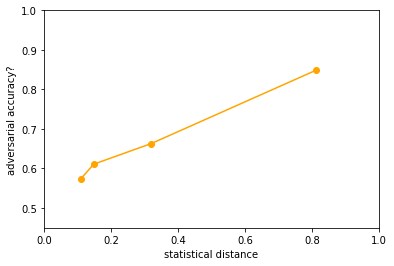

In [455]:
plt.plot(stat_dists, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy?')
plt.show()